# Car Price Prediction

---

## Table of Contents
1. Goal of this Project
2. Checking the Data
3. Cleaning the Data
4. Exploratory Data Analysis (EDA)
5. Feature Engineering 
6. Normalization
7. Regression
    - Cross Validation
    - Hyperparameter Tuning


8. Conclusion


#### NOTE: FIND WAY TO LINK TABLE OF CONTENTS

---

</br>



## 1. Goal of this Project

---

**The Motivation:** The last couple of months I have been working on exploring different machine learning methods (see: https://github.com/ryanirl/ml-basics), but have not actually applied any of my skills to real data sets. So I wanted to combine 2 of my previous projects and start doing some real data analysis. These 2 projects being the ml-basics linked above and the very first real programming project I ever worked on, that being: https://github.com/ryanirl/CraigslistScraper, which I originally built to scrape craigslist for car data to help me find cars. So I though I would bring my 2 interests together and do a project relating to predicting the price of car data.


Before we start, we must first import that data and read it into a Pandas DataFrame.

In [1]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Reading in the Data
df = pd.read_csv('vehicles.csv')

In [3]:
df

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,...,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,...,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,...,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,...,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,...,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600


</br>

## 2. Checking the Data

---

### Important features of the Dataset:

1. Price
2. Year
3. Manufacturer
4. Model
5. Condition
6. Cylinders
7. Size
8. Type
9. Paint Color

All other features will be irrelevent in the grand scheme of things. Also, because we are given Manufacturer I am going to remove Model because working with this feature is too subjective to human input error. I am also going to remove Paint Color because I don't believe this is too important, again in the grand scheme of things. This leaves us with 7 Key Features.

Before we start checking the data I am first going to remove any features that aren't part of our 7 key features list.



In [4]:
# NOTE: Is keeping ID a good idea?
bad_features = ['posting_date', 'state', 'county', 'image_url', 'region_url', 'paint_color', 'region_url', 'description',
                'id', 'url', 'model', 'region', 'VIN', 'long', 'lat']

df.drop(bad_features, inplace=True, axis=1)

df

,price,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type
0,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
426875,23590,2019.0,nissan,good,6 cylinders,gas,32226.0,clean,other,fwd,NaN,sedan
426876,30590,2020.0,volvo,good,NaN,gas,12029.0,clean,other,fwd,NaN,sedan
426877,34990,2020.0,cadillac,good,NaN,diesel,4174.0,clean,other,NaN,NaN,hatchback
426878,28990,2018.0,lexus,good,6 cylinders,gas,30112.0,clean,other,fwd,NaN,sedan


In [5]:
df.describe()

,price,year,odometer
count,4.268800e+05,425675.000000,4.224800e+05
mean,7.519903e+04,2011.235191,9.804333e+04
std,1.218228e+07,9.452120,2.138815e+05
min,0.000000e+00,1900.000000,0.000000e+00
25%,5.900000e+03,2008.000000,3.770400e+04
50%,1.395000e+04,2013.000000,8.554800e+04
75%,2.648575e+04,2017.000000,1.335425e+05
max,3.736929e+09,2022.000000,1.000000e+07


In [6]:
from scipy import stats

x = df[['year', 'odometer', 'price']]
x_sample = x.dropna().sample(10000)

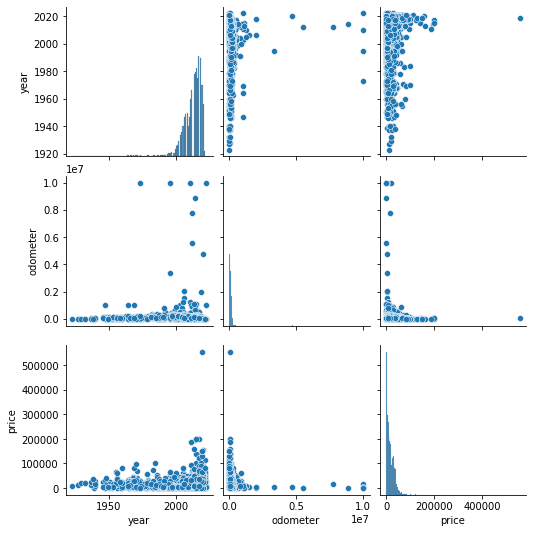

In [7]:
sb.pairplot(x_sample, hue=None)

### Outliers

We can see that ouliers are damaging our dataset so lets remove them.

In [8]:
z_sample = np.abs(stats.zscore(x_sample))
removed_outliers =  x_sample[(z < 3).all(axis=1)]

# sb.boxplot(x=x_sample['odometer'])

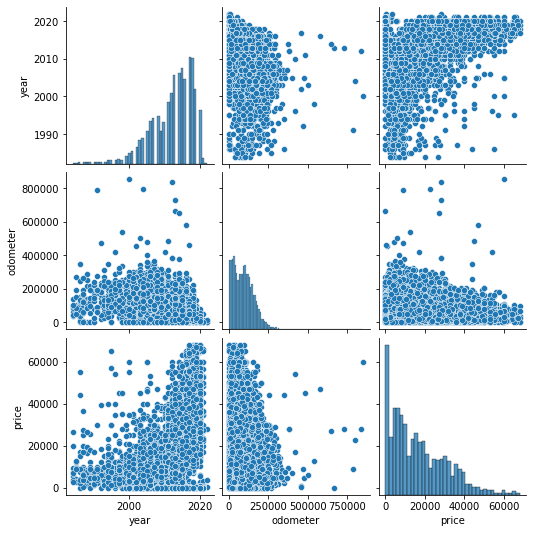

In [9]:
sb.pairplot(removed_outliers, hue=None)

In [10]:
# Now applying this fix to our whole dataset rather than just the sample set.